This can be used to solve initial value problems of the form $\frac{dx}{dt}=f(t,x)$, $x(t_0) = x_0$ using either explicit or diagonally implicit Runge Kutta methods, defined in the form of a Butcher Tableau. More information can be found here https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods.

## Implementation

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def newton(F, jacobian, x_0, t, epsilon, max_iterations = None):
    """
    Performs Newton's method to find a root of a given equation F(x) = 0 within error epsilon. The equation can be
    of arbitrary dimension.
    
    Parameters:
    F: The function F you want to find the root of - should return an np array.
    jacobian: A function which returns the Jacobian matrix (as an np array) of F evaluated at a point.
    x_0: An initial starting estimate for the algorithm.
    t: The time we are finding the root at (practically acts as a parameter for F).
    epsilon: A bound on the norm of F. Stop the algorithm and output our root if we reach within this bound.
    max_iterations: A number of iterations. If we do more than this many iterations then terminate the process.
    
    Returns:
    The root we have found.
    
    Raises:
    RuntimeError: If the method does not converge by max_iterations.
    
    """
    x = x_0
    F_x = F(t, x)
    k = 0
    while np.linalg.norm(F_x) > epsilon:
        jacobian_x = jacobian(t, x)
        if (F_x.size > 1):
            delta = np.linalg.solve(jacobian_x, F_x)
        else:
            delta = F_x[0] / jacobian_x[0]
        x = x - delta
        k += 1
        F_x = F(t, x)
        if max_iterations is not None and k > max_iterations:
            raise RuntimeError("Newton method did not converge")
    return x

In [3]:
def make_runge_kutta_F(f, h, t, alpha, z, beta):
    """
    A helper function used to make the function F for the Newton method in the diagonally implicit
    case.
    """
    def runge_kutta_F(t, x):
        return x - f(t + alpha * h, z + h * beta * x)
    return runge_kutta_F

In [4]:
def make_runge_kutta_jacobian(df, h, t, alpha, z, beta):
    """
    A helper function used to make the derivative matrix df for the Newton method in the 
    diagonally implicit case.
    """
    def runge_kutta_jacobian(t, x):
        return np.eye(x.size) - h * beta * df(t + alpha * h, z + h * beta * x)
    return runge_kutta_jacobian

In [5]:
def runge_kutta(f, butcher, T, h, y_0, df = None, epsilon = None, max_iterations = None):
    """
    Performs the Runge Kutta method to solve the ODE from time 0 to T.
    
    Parameters:
    f: The right hand side function f.
    butcher: An np array representing the butcher tableau of the method used.
    T: The final time to solve the IVP at.
    h: The timestep.
    y_0: An np array containing the initial value at t = 0.
    df: Only needed in the diagonally implicit case. A function which returns the Jacobian matrix 
        (as an np array) of f evaluated at a point.
    epsilon: Only needed in the diagonally implicit case. The bound for Newton's method.
    max_iterations: Only needed in the diagonally implicit case. Maximum iterations for Newton's method.
    
    Returns:
    t: An np array of times which the IVP is solved on.
    t_sol: An np array of solutions to the IVP at timesteps in t.
    """
    N = int(T / h)
    t = np.array([0])
    dimension = y_0.size
    y_sol = np.array(y_0)
    
    m = butcher.shape[0] - 1
    alpha = np.array([butcher[i, 0] for i in range(m)])
    gamma = butcher[-1][1:]
    beta = butcher[0:-1, 1:]
    
    for j in range(N):
        y_n = y_sol[-1]
        for i in range(1, m + 1):
            q = i - 1
            if beta[q, q] == 0:
                if q == 0:
                    k = np.array([f(t[-1], y_n)])
                    phi = gamma[0] * k[0]
                else:
                    sum_beta_k = 0
                    for l in range(q):
                        sum_beta_k += beta[q, l] * k[l]
                    z = y_n + h * sum_beta_k
                    k = np.vstack((k, np.array(f(t[-1] + alpha[q] * h, z))))
                    phi += gamma[q] * k[q]
            else:
                if i == 0:
                    z = y_n
                else:
                    sum_beta_k = 0
                    for l in range(q):
                        sum_beta_k += beta[q, l] * k[l]
                    z = y_n + h * sum_beta_k
                F = make_runge_kutta_F(f, h, t[-1], alpha[q], z, beta[q, q])
                jacobian = make_runge_kutta_jacobian(df, h, t[j], alpha[q], z, beta[q, q])
                if q == 0:
                    k = np.array([newton(F, jacobian, f(t[-1] + alpha[q], z), t[-1], epsilon, max_iterations)])
                    phi = gamma[0] * k[0]
                else:
                    k = np.vstack(k, np.array([newton(F, jacobian, f(t[-1] + alpha[q], z), t[-1], epsilon, max_iterations)]))
                    phi += gamma[q] * k[q]
        y_sol = np.vstack((y_sol, y_n + h * phi))
        t = np.vstack((t, t[-1] + h))
    return t, y_sol

## Example

An example of both an explicit and implicit method to solve the equation $\frac{dy}{dt} = (1.5 - y + \sin(2t))^2 + 2cos(2t)$, $y(0) = 1$.

I have used both Heun's method and the Backward Euler method up to T = 10, and graphed the solutions given. I have also graphed the exact solution to show that the methods work.

In [6]:
def f_eq_diff2(t, y):
    return np.array([((1.5 - y + math.sin(2 * t)) ** 2) + 2 * math.cos(2 * t)])

In [7]:
def der_f_eq_eq_diff2(t, y):
    return np.array([-2 * math.sin(2 * t) + 2 * y - 3])

In [8]:
def exact_sol_diff2(h, T):
    N = int(T / h)
    times = [i * h for i in range(N + 1)]
    sol = np.array([])
    for t in times:
        numerator = 1 + t * 1.5 * (1.5 - 1)
        denominator = 1 + t * (1.5 - 1)
        sol = np.append(sol, [math.sin(2 * t) + (numerator / denominator)])
    return sol

In [9]:
heun = np.array([[0, 0  , 0  ],
                 [1, 1  , 0  ],
                 [0, 0.5, 0.5]])

backward_euler = np.array([[0, 1],
                           [0, 1]])

In [10]:
exact_sol = exact_sol_diff2(0.001, 10)

In [11]:
t, sol = runge_kutta(f_eq_diff2, heun, 10, 0.001, np.array([1]))

In [12]:
t, sol = runge_kutta(f_eq_diff2, backward_euler, 10, 0.001, np.array([1]), der_f_eq_eq_diff2, 0.0001, 500)

Text(0.5, 1.0, 'Exact Solution')

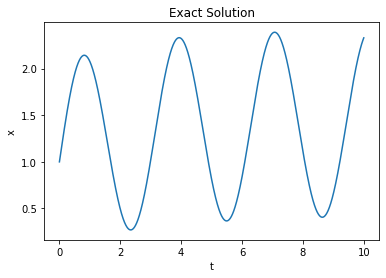

In [13]:
plt.plot(t, exact_sol)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact Solution")

Text(0.5, 1.0, 'Heun')

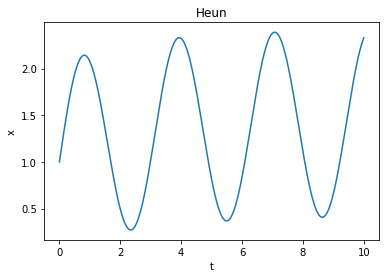

In [14]:
plt.plot(t, sol)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Heun")

Text(0.5, 1.0, 'Backward Euler')

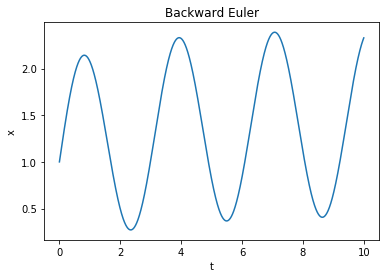

In [15]:
plt.plot(t, sol)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Backward Euler")